# Cas Kaggle ApC - Mushroom Classification - Problema de classificació binària

## Descripció del dataset
Aquest dataset inclou descripcions de mostres hipotètiques que corresponen a 23 espècies de bolets de les famílies Agaricus i Lepiota. Cada espècia s'identifica com a "definitivament comestible" (definitely edible), com a "definitivament verinosa" (definitely poisonous) o "comestibilitat desconeguda" (unknown edibility).

**Objectiu**: Preveure si un bolet concret és comestible o no basat en les seves característiques físiques.

**Important a tenir en compte**: Estem davant d'un cas on la seguretat és molt important, per tant els "falsos negatius" poden ser letals. És degut a això que haurem de prioritzar el **recall** de la classe "verinosa" (poisonous).


## 1. Setup and Data Loading


In [11]:
# Importació de llibreries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


In [ ]:
# Carreguem el dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data'
column_names = [
    'class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
    'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
    'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
    'stalk-surface-below-ring', 'stalk-color-above-ring',
    'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
    'ring-type', 'spore-print-color', 'population', 'habitat'
]

df = pd.read_csv(url, names=column_names)
print("Dataset loaded from UCI repository successfully!")

print(f"\nFirst rows:")
df.head()


Dataset loaded from UCI repository successfully!

Dataset shape: (8124, 23)

First few rows:


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


## 2. Exploratory Data Analysis (EDA)


In [3]:
# Dataset overview
print("Dataset shape:", df.shape)
print("\nData types:")
print(df.dtypes.value_counts())
print("\nDuplicates:", df.duplicated().sum())


Dataset shape: (8124, 23)

Data types:
object    23
Name: count, dtype: int64

Duplicates: 0


In [5]:
# Target distribution
print("Target class distribution:")
print(df['class'].value_counts())
print("\nPercentage:")
print(df['class'].value_counts(normalize=True) * 100)


Target class distribution:
class
e    4208
p    3916
Name: count, dtype: int64

Percentage:
class
e    51.797144
p    48.202856
Name: proportion, dtype: float64


In [6]:
# Missing values check
print("Missing values represented as '?':")
missing_data = []
for col in df.columns:
    missing_count = (df[col] == '?').sum()
    if missing_count > 0:
        missing_data.append({'Feature': col, 'Missing': missing_count, 'Percentage': f"{missing_count/len(df)*100:.2f}%"})

if missing_data:
    print(pd.DataFrame(missing_data))
else:
    print("No missing values found")


Missing values represented as '?':
      Feature  Missing Percentage
0  stalk-root     2480     30.53%


In [8]:
# Feature cardinality
print("Unique values per feature:\n")
for col in df.columns:
    unique_count = df[col].nunique()
    print(f"{col:30} {unique_count} unique values")
    
# Check for zero-variance features
zero_var_features = [col for col in df.columns if df[col].nunique() == 1]
if zero_var_features:
    print(f"\nZero variance features: {zero_var_features}")


Unique values per feature:

class                          2 unique values
cap-shape                      6 unique values
cap-surface                    4 unique values
cap-color                      10 unique values
bruises                        2 unique values
odor                           9 unique values
gill-attachment                2 unique values
gill-spacing                   2 unique values
gill-size                      2 unique values
gill-color                     12 unique values
stalk-shape                    2 unique values
stalk-root                     5 unique values
stalk-surface-above-ring       4 unique values
stalk-surface-below-ring       4 unique values
stalk-color-above-ring         9 unique values
stalk-color-below-ring         9 unique values
veil-type                      1 unique values
veil-color                     4 unique values
ring-number                    3 unique values
ring-type                      5 unique values
spore-print-color             

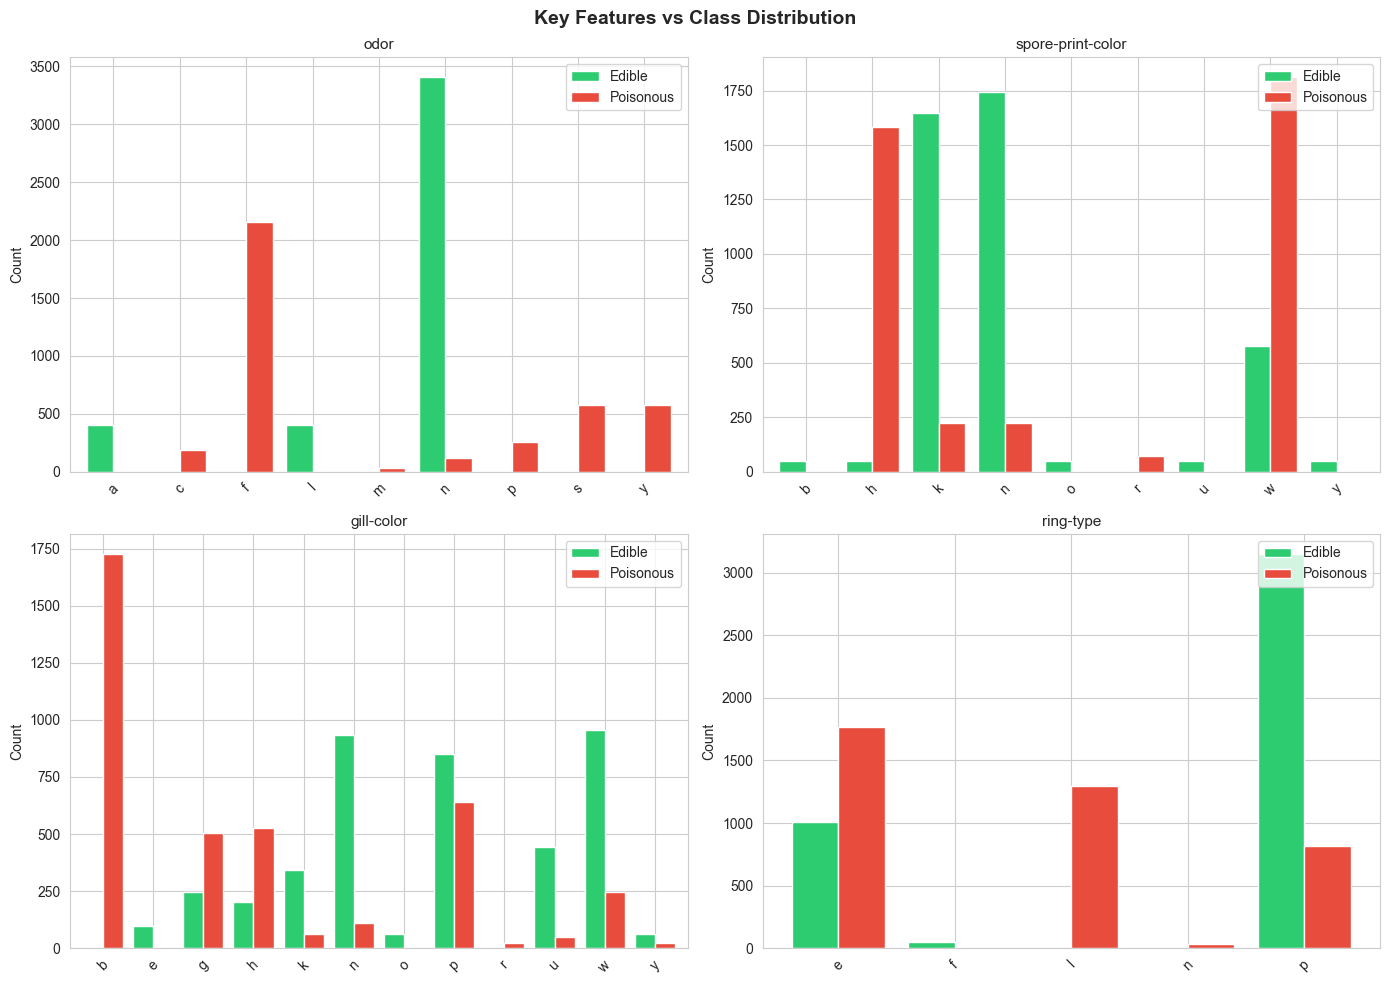

In [12]:
# Bivariate analysis - key features vs target
key_features = ['odor', 'spore-print-color', 'gill-color', 'ring-type']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Key Features vs Class Distribution', fontsize=14, fontweight='bold')

for idx, feature in enumerate(key_features):
    ax = axes[idx // 2, idx % 2]
    
    crosstab = pd.crosstab(df[feature], df['class'])
    crosstab.plot(kind='bar', ax=ax, color=['#2ecc71', '#e74c3c'], width=0.8)
    
    ax.set_title(f'{feature}', fontsize=11)
    ax.set_xlabel('')
    ax.set_ylabel('Count')
    ax.legend(['Edible', 'Poisonous'], loc='upper right')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [ ]:
# Odor feature (normalment és la feature més discriminativa, tal com hem vist en l'anàlisis anterior)
print("Odor distribution by class:")
odor_class = pd.crosstab(df['odor'], df['class'], margins=True)
print(odor_class)

# Check if any odor value perfectly predicts class
print("\n🔍 Odor values and their class association:")
for odor_val in df['odor'].unique():
    subset = df[df['odor'] == odor_val]
    class_dist = subset['class'].value_counts()
    if len(class_dist) == 1:
        print(f"  '{odor_val}': 100% {class_dist.index[0]} ({len(subset)} samples)")


Odor distribution by class:
class     e     p   All
odor                   
a       400     0   400
c         0   192   192
f         0  2160  2160
l       400     0   400
m         0    36    36
n      3408   120  3528
p         0   256   256
s         0   576   576
y         0   576   576
All    4208  3916  8124

🔍 Odor values and their class association:
  'p': 100% p (256 samples)
  'a': 100% e (400 samples)
  'l': 100% e (400 samples)
  'f': 100% p (2160 samples)
  'c': 100% p (192 samples)
  'y': 100% p (576 samples)
  's': 100% p (576 samples)
  'm': 100% p (36 samples)


### Análisis final

1. **Mida Dataset**: 8124 bolets amb 23 features (totes categòriques)
   - Això ens indica que el dataset és prou gran per l'entrenament, a més a més el fet de que totes siguin categòriques ens indica que els models basats en arbres són ideals per un cas com el nostre.

2. **Balanceig de classes**: El dataset està molt ben balancejat (~52% edible, ~48% poisonous)
   - Per tant ja sabem que no necessitem tècniques de "resampling".

3. **Valors faltants**: Hem observat que la feature `stalk-root` té prop del 30% de valors faltants (?).
   - Necessitem gestionar això abans de modelar, ja sigui afegint valors o fent "drops". 

4. **Features amb zero variància**: `veil-type` té un únic valor en tots els casos.
   - Sabem per tant que no ens aporta cap tipus d'informació i en el preprocessament de dades la podrem esborrar.

5. **Features Discriminants**: 
   - **Odor** és molt discriminativa - alguns valors preveuen per si sols la classe a la perfecció.
   - **Spore-print-color** i **gill-color** també mostren força discriminació.
   - Aquest4es features molt possiblement dominaran la predicció del nostre model.

6. **Separabilitat perfecta**: Algunes features amb uns valors concrets estan 100% associades a una classe.
   - Sabent això, en principi hauríem de ser capaços d'aconseguir un model amb una alta "accuracy".
